In [0]:
import csv
import cv2
import matplotlib.pyplot as plt
import numpy as np
import operator
import os
from psutil import cpu_count
import string
import time

from collections import Counter,defaultdict
from keras.models import model_from_json 

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Using TensorFlow backend.


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# CHOOSE DATASET YOU WANT TO EVALUATE
reid = True
hdr = False

Download test dataset

In [0]:
if hdr:
    zip_path = '/content/drive/My Drive/KNN/HDR_dataset.zip'
    !cp "{zip_path}" .
    !unzip -q -n 'HDR_dataset.zip' -d './HDR'
if reid:
    zip_path = '/content/drive/My Drive/KNN/2017-IWT4S-CarsReId_LP-dataset.zip'
    !cp "{zip_path}" .
    !unzip -q -n '2017-IWT4S-CarsReId_LP-dataset.zip' -d './REID'

read test dataset

In [0]:
def add_blank_chars(label):
    empty_cnt = 8 - len(label)
    empty_c = ''
    for i in range(0, empty_cnt):
        empty_c += '#'
    second_part_beg = len(label) - 4
    new_end = empty_c + label[second_part_beg:]
    first_part_delim = 8 - len(new_end)
    return label[:first_part_delim] + new_end



if hdr:
    hdr_dataset_images = []
    hdr_dataset_labels = []
    with open('HDR/trainVal.csv', 'r') as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=';')
        line_count = 0
        for row in csv_reader:
            if line_count == 0:
                # Skip header row
                line_count += 1
            else:
                if (len(row[2]) != 8):
                    label = add_blank_chars(row[2])
                else:
                    label = row[2]
                img = cv2.imread(os.path.join('./HDR',row[1][2:]))
                if img is None:
                    continue
                img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
                normalizedImg = np.zeros((200, 40))
                normalizedImg = cv2.normalize(img,  normalizedImg, 0, 255, cv2.NORM_MINMAX)
                res = cv2.resize(normalizedImg, dsize=(200, 40), interpolation=cv2.INTER_CUBIC)
                hdr_dataset_labels.append([label])
                hdr_dataset_images.append(res)

    hdr_dataset_images = np.asarray(hdr_dataset_images)
    hdr_dataset_labels = np.asarray(hdr_dataset_labels)

if reid:
    reid_dataset_images = []
    reid_dataset_labels = []
    with open('REID/trainVal.csv', 'r') as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        line_count = 0
        for row in csv_reader:
            if line_count == 0:
                # Skip header row
                line_count += 1
            else:
                if int(row[3]) == 0:
                    if (len(row[2]) != 8):
                        label = add_blank_chars(row[2])
                    else:
                        label = row[2]
                    img = cv2.imread(os.path.join('./REID',row[1]))
                    if img is None:
                        continue
                    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
                    normalizedImg = np.zeros((200, 40))
                    normalizedImg = cv2.normalize(img,  normalizedImg, 0, 255, cv2.NORM_MINMAX)
                    res = cv2.resize(normalizedImg, dsize=(200, 40), interpolation=cv2.INTER_CUBIC)
                    reid_dataset_labels.append([label])
                    reid_dataset_images.append(res)


    reid_dataset_images = np.asarray(reid_dataset_images)
    reid_dataset_labels = np.asarray(reid_dataset_labels)

=================reid=============================


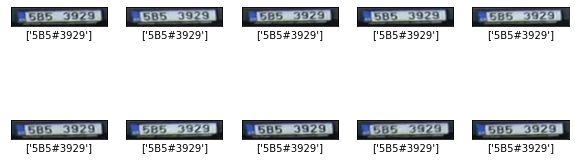

In [0]:
def show_some_examples(images, labels):
    plt.figure(figsize=(10,10))
    for i in range(10):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.binary)
        plt.xlabel(labels[i])
    plt.show()



if hdr:
    print('=================hdr=============================')
    show_some_examples(hdr_dataset_images, hdr_dataset_labels)

if reid:
    print('=================reid=============================')
    show_some_examples(reid_dataset_images, reid_dataset_labels)

Evaluate accuracy of model on test dataset, calculate and print statistics

In [0]:
# decode to license plate characters
map_numbers_to_char = {}
for i,d in enumerate(string.digits+string.ascii_uppercase + '#'):
    map_numbers_to_char[i] = d

# transform nn output into list with license plate characters
def get_readable_prediction(nn_output):
    idxs = [np.argmax(x) for x in nn_output]
    lp = [map_numbers_to_char[idx] for idx in idxs]
    return lp


# comapre two lists, count statistics 
def is_prediction_right(lstPrediction, lstLabel, statistics):
    lstPrediction = np.array(lstPrediction)
    lstLabel = np.array(lstLabel)
    # debug
    # print('lstPrediction:', lstPrediction)
    # print('lstLabel     :', lstLabel)
    if (lstPrediction==lstLabel).all():
        statistics['total_chars'] += len(lstPrediction)
        return True
    else:
        for j, char in enumerate(lstLabel):
            if char != lstPrediction[j]:
                statistics['branch_list'][j].append(char)
                statistics['chars_count'] += 1
            statistics['total_chars'] += 1
        return False


def test_weights(loaded_model, images, labels, chars_stats_counter, get_chars_stats=False):
    total = len(images)
    same_as_label = 0
    branch_list = [[] for _ in range(8)]
    statistics = {'chars_count': 0, 'total_chars': 0, 'branch_list':branch_list}

    # # debug
    # print (statistics)
    # print(list(labels[0][0]))
    # print(get_readable_prediction(prediction_1_lp))

    time_measurements = {'start':0,'end':0}
    for i, image in enumerate(images):
        start = time.clock()  
        lp_prediction = loaded_model.predict(np.asarray([image]))
        end = time.clock()
        time_measurements['start'] += start
        time_measurements['end'] += end
        readable_prediction = get_readable_prediction(lp_prediction)
        if is_prediction_right(
            readable_prediction, 
            list(labels[i][0]),
            statistics
            ): 
            same_as_label += 1

    print("successfuly recognized: ", same_as_label)
    print("total: ", total)
    success_rate = same_as_label/total*100
    print("successful rate: {}%".format(str(round(success_rate, 2))))

    print("error rate [%] (character/license plate): {}/{}".format(
        str(round(
            statistics['chars_count']/statistics['total_chars']*100,
            2
            )),
         str(round((100 - success_rate), 2)),
    ))
    time_per_image = ((time_measurements['end'] - time_measurements['start'])
                      /len(images))
    print("Time per image: {} ".format( str(round(time_per_image, 10)))) 

    chars_stats = [Counter(x )for x in statistics['branch_list']]
    if get_chars_stats:
        chars_stats_counter.append(chars_stats)
    return success_rate


# print(statistics)

Load every model and weights and print all of them and the best one at the end

In [0]:
path_to_model = '/content/drive/My Drive/KNN/varlen.json'
path_to_weights = '/content/drive/My Drive/KNN/varlen-{}.hdf5'
range_from = 27 # default: 1
range_to = 28  # default: epochs num +1 

def run_statistics(images, labels, dataset_name, range_from, range_to):
    chars_stats_counter = []
    best_weights = []
    print('====================================================')
    for i in range(range_from,range_to):
        start = time.clock()  
        if i < 10:
            path_weights = path_to_weights.format('0' + str(i))
        else:
            path_weights = path_to_weights.format(i)
        # load json and create model
        json_file = open(path_to_model, 'r')
        loaded_model_json = json_file.read()
        json_file.close()
        loaded_model = model_from_json(loaded_model_json)
        # load weights into new model
        loaded_model.load_weights(path_weights)
        print('-------------dataset {}, model {}------------------'.format(dataset_name, i))
        best_weights.append(test_weights(loaded_model, images, labels, chars_stats_counter))
        end = time.clock()
        print('this calculation takes {}'.format(end-start))
    idx = best_weights.index(max(best_weights))
    idx += range_from  # numbering from 1 not from zero
    print()
    print('****************************************************')
    print('best model index:', idx)
    if idx < 10:
        path_weights = path_to_weights.format('0' + str(idx))
    else:
        path_weights = path_to_weights.format(idx)

    json_file = open(path_to_model, 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    # load weights into new model
    loaded_model.load_weights(path_weights)
    print('-------------dataset {}, model {}------------------'.format(dataset_name, idx))
    _ = test_weights(loaded_model, images, labels, chars_stats_counter, True)
    print('****************************************************')
    print()
    return chars_stats_counter

if hdr:
    chars_stats_counter_hdr = run_statistics(hdr_dataset_images, hdr_dataset_labels, 'hdr', range_from, range_to)
if reid:
    chars_stats_counter_reid = run_statistics(reid_dataset_images, reid_dataset_labels, 'reid', range_from, range_to)


-------------dataset reid, model 27------------------
successfuly recognized:  71872
total:  76412
successful rate: 94.06%
error rate [%] (character/license plate): 1.47/5.94
Time per image: 0.0086562933 
this calculation takes 668.092703

****************************************************
best model index: 27
-------------dataset reid, model 27------------------


In [0]:
# get hardware info
print(cpu_count())
!cat /proc/cpuinfo | grep 'model name'
!nvidia-smi -L
!nvidia-smi

In [0]:
def get_all_used_chararcters(labels):
    all_used_chars = []
    for item in labels:
        chars = list(item[0])
        for char in chars:
            if char not in all_used_chars:
                all_used_chars.append(char)
    return all_used_chars

def character_analysis(c, all_labeled_chars=None):
    # c = [Counter({'8': 9, '9': 6, '2': 6, '7': 6, '1': 5, 'B': 4, '5': 4, '6': 4, '3': 3, '4': 2, 'L': 2, 'F': 2, 'D': 2, 'S': 2, 'Z': 1}), Counter({'B': 16, 'Z': 11, 'M': 7, 'T': 5, 'A': 3, 'H': 2, 'I': 2, 'N': 1, '0': 1, 'S': 1, 'J': 1, 'E': 1}), Counter({'1': 9, '0': 8, '6': 6, '7': 6, 'D': 4, 'I': 4, '4': 4, 'J': 4, 'Z': 3, '5': 3, 'E': 2, 'T': 2, '3': 2, '9': 2, 'N': 2, 'H': 1, 'P': 1, 'A': 1, 'X': 1, 'C': 1, '8': 1, 'B': 1}), Counter({'7': 9, '6': 6, '8': 5, '1': 4, '3': 4, '5': 3, '2': 3, '4': 3, '0': 2, '9': 1}), Counter({'8': 11, '3': 11, '9': 8, '2': 7, '4': 7, '1': 6, '6': 6, '7': 6, '0': 2}), Counter({'3': 14, '7': 8, '2': 6, '5': 6, '1': 5, '4': 5, '8': 4, '9': 4, '6': 4, '0': 4, 'B': 3, 'J': 2}), Counter({'4': 14, '5': 14, '8': 11, '3': 10, '7': 8, '9': 7, '6': 5, '1': 4, '0': 4, '2': 4, 'G': 2, 'C': 1})]
    # print(c)
    for i, x in enumerate(c):
        freqword = defaultdict(list)
        print(x)
        for word, freq in x.items():
            freqword[freq].append(word)

        # print in order of occurrence (with sorted list of words)

        wrong_char_in_column = 0
        for freq in sorted(freqword,reverse=True):
            print('col: {}- mistakes: {}: char: {}'.format(i+1, freq, sorted(freqword[freq])))
            wrong_char_in_column += freq
        print("column {} mistakes {}".format(i+1,wrong_char_in_column))

    freqword = {}
    for i, x in enumerate(c):
        for word, freq in x.items():
            freqword[word] = 0

    for i, x in enumerate(c):
        for word, freq in x.items():
            freqword[word] += freq

        # print in order of occurrence (with sorted list of words)
    sorted_x = sorted(freqword.items(), key=operator.itemgetter(1))
    print("mistakes_together", sorted_x)

    y_map = [x for x in(string.digits+string.ascii_uppercase)]
    print(y_map)

    lst = []
    for x in sorted_x:
        for a in x:
            lst.append(a)

    print(lst)
    zero_mistakes = list(set(y_map) - set(lst))
    if all_labeled_chars:
        characters_that_do_not_exist_in_dataset =  list(set(y_map) - set(all_labeled_chars))
        print("1",zero_mistakes)
        print("2",characters_that_do_not_exist_in_dataset)
        print("zero mistakes: ", list(set(zero_mistakes) - (set(characters_that_do_not_exist_in_dataset))))
    else:
        print("zero mistakes: ", zero_mistakes)

In [0]:
# chars_stats_counter is only from the best index, if index of best epoch is wrong, you need to get chars_stats_counter manually
if hdr:
    print('=================hdr=============================')
    all_labeled_chars = get_all_used_chararcters(hdr_dataset_labels)
    character_analysis(chars_stats_counter_hdr[0], all_labeled_chars)
# takes too long
if reid:
    print('=================reid============================')
    all_labeled_chars = get_all_used_chararcters(reid_dataset_labels)
    character_analysis(chars_stats_counter_reid[0], all_labeled_chars)
